In [1]:
import pyximport
pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
from gammapy.maps import Map
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    GaussianSpatialModel,
    Models,
    FoVBackgroundModel,
)
import sys
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [2]:
figformat = 'png'

In [3]:
ampli = Parameter("amplitude", value = 1e-12)


dataset_asimov = Dataset_load.create_asimov(source = "PKSflare", model = 'pl', parameters = Parameters([ampli]))
dataset_asimov_cl = Dataset_load.create_asimov(source = "PKSflare", model = 'pl', parameters = Parameters([ampli]))
dataset_input = Dataset_load.create_asimov(source = "PKSflare", model = 'pl', parameters = Parameters([ampli]))
datasets = [dataset_asimov, dataset_asimov_cl, dataset_input]
for d in datasets:
    d.counts = d.npred()

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz


In [4]:
source = dataset_asimov.models[0].name
geom = dataset_asimov.exposure.geom
coords = geom.get_coord(sparse=True)
rad = coords.skycoord.separation(geom.center_skydir)
rad.shape

(1, 500, 500)

In [5]:
from gammapy.irf import PSFMap, PSFKernel

def create_gaussian(psf, sigma, rad = dataset_asimov.psf.psf_map.geom.axes['rad'],
                   geom = dataset_asimov.psf.psf_map.geom.to_image()):

    psf_map_g = PSFMap.from_gauss(energy_axis_true = psf.psf_map.geom.axes['energy_true'],
                        sigma = sigma*u.deg,
                          geom =geom ,
                          rad_axis = rad,
                         )
    
    psf_kernel_g = psf_map_g.get_psf_kernel(dataset_asimov.exposure.geom)
    psf_kernel_g.to_image().psf_kernel_map.reproject_to_geom(geom, preserve_counts=True).plot(ax=None, add_cbar=1)
    return psf_map_g, psf_kernel_g

from astropy.visualization import quantity_support
from matplotlib.ticker import FormatStrFormatter
def plot_psf_vs_rad(psf, ax=None, energy_true=[0.1, 1, 10] * u.TeV,energy_name='energy', label = None,**kwargs):
    """Plot PSF vs radius.

    The method plots the profile at the center of the map.

    Parameters
    ----------
    ax : `~matplotlib.pyplot.Axes`
        Axes to plot on.
    energy : `~astropy.units.Quantity`
        Energies where to plot the PSF.
    **kwargs : dict
        Keyword arguments pass to `~matplotlib.pyplot.plot`.

    Returns
    -------
    ax : `~matplotlib.pyplot.Axes`
         Axes to plot on.

    """
    ax = plt.gca() if ax is None else ax

    rad = psf.psf_map.geom.axes["rad"].center

    for value in energy_true:
        psf_value = psf.psf_map.interp_by_coord(
            {
                "skycoord": psf.psf_map.geom.center_skydir,
                energy_name: value,
                "rad": rad,
            }
        )
        #if label is None:
        label_ = f"{value}" +label
        with quantity_support():
            ax.plot(rad**2, psf_value, label=label_, **kwargs)

    ax.set_yscale("log")
    ax.set_xlabel(f"Rad **2  ({ax.xaxis.units})")
    ax.set_ylabel(f"PSF ({ax.yaxis.units})")
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    plt.legend()
    return ax

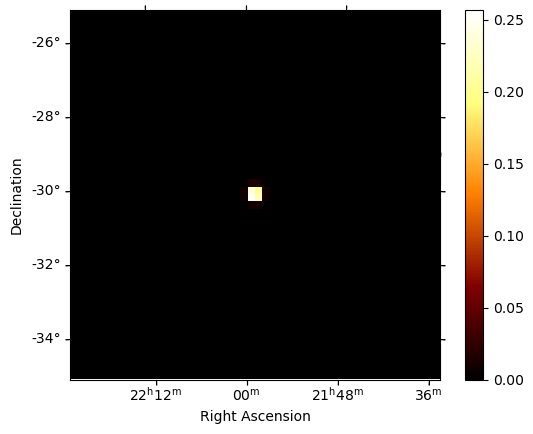

In [6]:
psf_map = dataset_asimov.psf
psf_kernel = psf_map.get_psf_kernel(geom = dataset_asimov.exposure.geom)
psf_map_g, psf_kernel_g  = create_gaussian(psf_map, 0.1)


ev =dataset_asimov.evaluators[dataset_asimov.models[0].name] 
ev_cl =dataset_asimov_cl.evaluators[dataset_asimov_cl.models[0].name] 


ev_cl.psf.to_image().psf_kernel_map.reproject_to_geom(geom.to_image(), preserve_counts=True).plot(ax=None, add_cbar=1)
ax = plt.gca()
ax.set_title(f"True PSF Kernel")


npred= ev_cl.compute_npred()
npred.sum_over_axes().plot(add_cbar= 1)
plt.title("npred true PSF")

ev.convolve_psf(psf_map_g)
ev.psf.to_image().psf_kernel_map.reproject_to_geom(geom.to_image(), preserve_counts=True).plot(ax=None, add_cbar=1)
ax = plt.gca()
ax.set_title(f"Convolved PSF Kernel")


npred_g= ev.compute_npred()
npred_g.reproject_to_geom(npred.geom, preserve_counts=True).sum_over_axes().plot(add_cbar= 1)
plt.title("npred convovled PSF")

## Shifting the model position

if parameters_spatial_changed is true:

needs_update is set to True


with dataset_asimov_cl.models.parameters.restore_status():
    dataset_asimov_cl.models.parameters['lon_0'].value= 329

    npred_cl_s= ev_cl.compute_npred()
    npred_cl_s.reproject_to_geom(npred.geom, preserve_counts=True).sum_over_axes().plot(add_cbar= 1)
    plt.title("npred convovled PSF")

with dataset_asimov.models.parameters.restore_status():
    dataset_asimov.models.parameters['lon_0'].value= 329

    npred_s= ev.compute_npred()
    npred_s.reproject_to_geom(npred.geom, preserve_counts=True).sum_over_axes().plot(add_cbar= 1)
    plt.title("npred convovled PSF")

## PSF Model

In [7]:
from gammapy.modeling.models.IRF import PSFIRFModel, IRFModels

In [8]:
psf_model =PSFIRFModel(sigma=0.)
irf_models = IRFModels(psf_model=psf_model,
                      datasets_names=dataset_asimov.name)

In [9]:
dataset_asimov.models = Models([dataset_asimov.models[0], irf_models, dataset_asimov.background_model])
print(dataset_asimov.models)
dataset_asimov.models.parameters['sigma_psf'].min = 0
sigma_ass = 1
dataset_asimov.penalising_invcovmatrix = [[1/sigma_ass**2]]

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: IRFModels

  Name                      : 1nZ1RO5N-irf
  Datasets names            : 1nZ1RO5N
  EReco  model type         : 
  Eff area  model type      : 
  PSF model type            : PSFIRFModel
  Parameters:
    sigma_psf                     :      0.001   +/-    0.00             

Component 2: FoVBackgroundModel

  Name                      : 1nZ1RO5N-bkg
  

compute gaussian for  sigma 1e-3 +  0.001


<WCSAxes: >

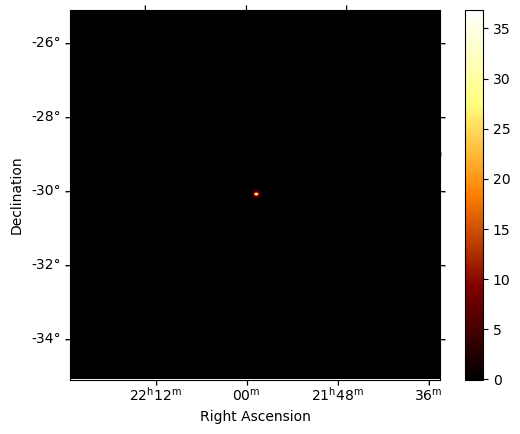

In [10]:
npred = dataset_asimov.npred_signal()
npred.sum_over_axes().plot(add_cbar =1)

compute gaussian for  sigma 1e-3 +  0.1
compute gaussian for  sigma 1e-3 +  0.01
compute gaussian for  sigma 1e-3 +  0.0001
CPU times: user 6.8 s, sys: 494 ms, total: 7.29 s
Wall time: 7.25 s


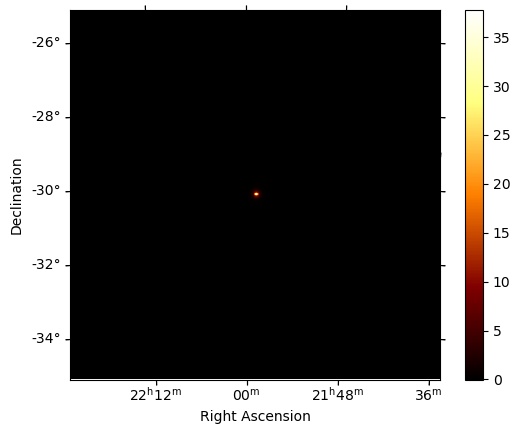

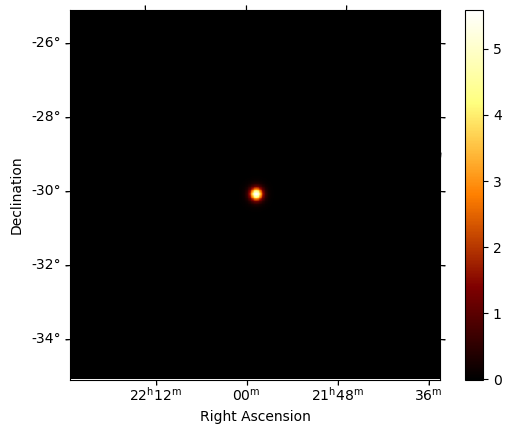

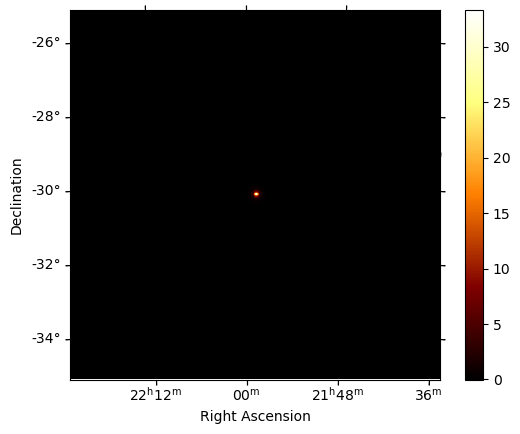

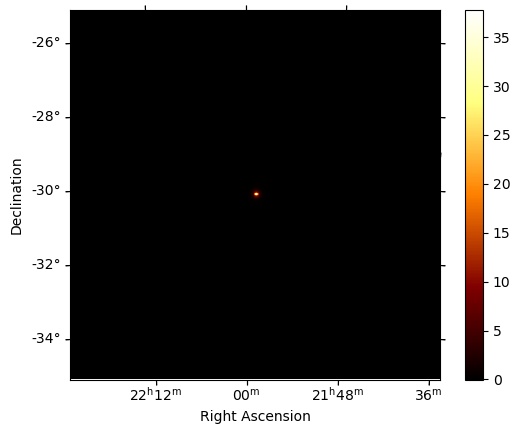

In [11]:
%%time
e_idx = 14 

npred_cl = dataset_asimov_cl.npred_signal()
plt.figure()
npred_cl.sum_over_axes().plot(add_cbar =1)  
vv = [1e-1, 1e-2, 1e-4, ]
for v in vv:
    with dataset_asimov.models.parameters.restore_status():
        dataset_asimov.irf_model.parameters['sigma_psf'].value = v
        npred = dataset_asimov.npred_signal()
        plt.figure()
        npred.sum_over_axes().plot(add_cbar =1)        



compute gaussian for  sigma 1e-3 +  0.01
compute gaussian for  sigma 1e-3 +  0.0001
CPU times: user 3.98 s, sys: 332 ms, total: 4.32 s
Wall time: 4.24 s


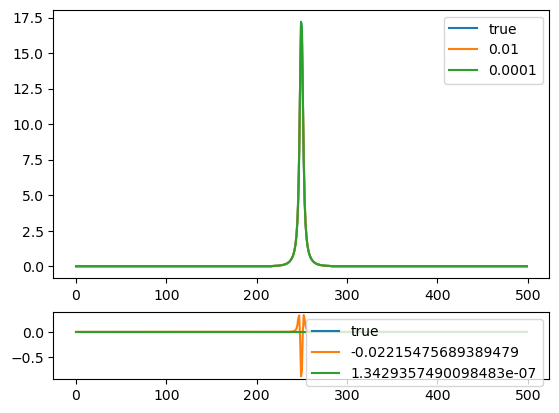

In [12]:
%%time
fig,(ax1, ax2) = plt.subplots(2,1 ,height_ratios=[4,1])
e_idx = 14 

npred_cl = dataset_asimov_cl.npred_signal()
ax1.plot(npred_cl.data[10, :,:].sum(axis=1), label = "true")
ax2.plot(npred_cl.data[10, :,:].sum(axis=1)-npred_cl.data[10, :,:].sum(axis=1) , 
             label  = "true")
vv = [1e-2, 1e-4, ]
for v in vv:
    with dataset_asimov.models.parameters.restore_status():
        dataset_asimov.irf_model.parameters['sigma_psf'].value = v
        npred = dataset_asimov.npred_signal()
        ax1.plot(npred.data[10, :,:].sum(axis=1), label = v)

        ax2.plot(npred.data[10, :,:].sum(axis=1)-npred_cl.data[10, :,:].sum(axis=1) , 
                 label  = np.sum(npred.data[10, :,:].sum(axis=1)-npred_cl.data[10, :,:].sum(axis=1)))


ax1.legend();ax2.legend();

## Prior Term

compute gaussian for  sigma 1e-3 +  0.0009999999999999998
compute gaussian for  sigma 1e-3 +  0.0014458231349729434
compute gaussian for  sigma 1e-3 +  0.0005868047114976443
compute gaussian for  sigma 1e-3 +  0.0009999999999999998
compute gaussian for  sigma 1e-3 +  0.0005868047114976443
compute gaussian for  sigma 1e-3 +  0.0002608512847102999
compute gaussian for  sigma 1e-3 +  2.6570585367169164e-05
compute gaussian for  sigma 1e-3 +  0.0038716884072404795
compute gaussian for  sigma 1e-3 +  0.0014786281592831113
compute gaussian for  sigma 1e-3 +  0.00042696263418708275
compute gaussian for  sigma 1e-3 +  1.2707643591755804e-05
compute gaussian for  sigma 1e-3 +  0.003942297323129766
compute gaussian for  sigma 1e-3 +  0.001544786788869042
compute gaussian for  sigma 1e-3 +  0.00047927627105141785
compute gaussian for  sigma 1e-3 +  0.00010285653135050946
compute gaussian for  sigma 1e-3 +  1.2707643591755804e-05
compute gaussian for  sigma 1e-3 +  5.6243048389817866e-05
compute g

<Axes: >

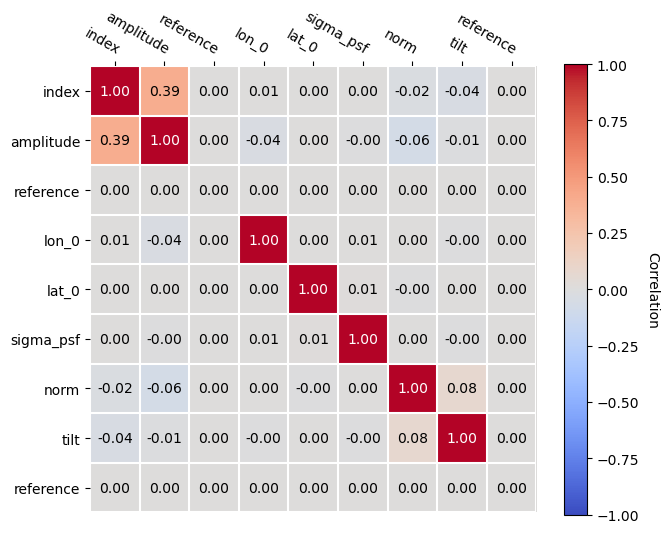

In [13]:
%%time
fit = Fit()
result = fit.run(dataset_asimov)
print(result)
dataset_asimov.models.covariance = fit.covariance(dataset_asimov).matrix
dataset_asimov.models.covariance.plot_correlation()

In [14]:
print(dataset_asimov.models)

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.05             
    amplitude                     :   1.00e-12   +/- 5.1e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: IRFModels

  Name                      : 1nZ1RO5N-irf
  Datasets names            : 1nZ1RO5N
  EReco  model type         : 
  Eff area  model type      : 
  PSF model type            : PSFIRFModel
  Parameters:
    sigma_psf                     :      0.000   +/-    0.53             

Component 2: FoVBackgroundModel

  Name                      : 1nZ1RO5N-bkg
  

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 100
	total stat : 850189.07

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 10.7 s, sys: 2.3 s, total: 13 s
Wall time: 13 s


<Axes: >

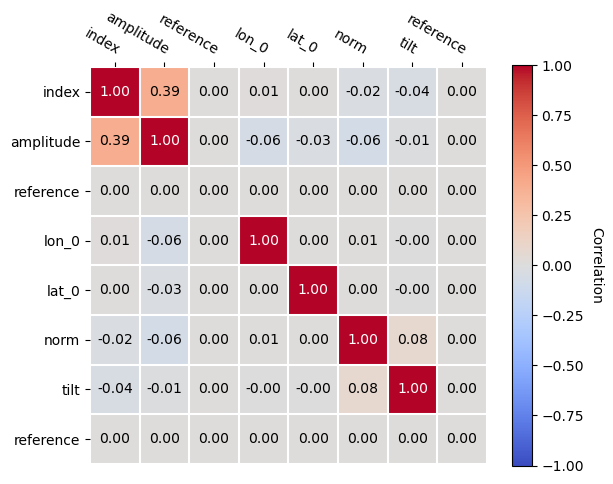

In [15]:
%%time
fit = Fit()
result= fit.run(dataset_asimov_cl)
print(result)
dataset_asimov_cl.models.covariance = fit.covariance(dataset_asimov_cl).matrix
dataset_asimov_cl.models.covariance.plot_correlation()

In [16]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    
    return ax

def plot_par_one(par1,x,  label,ax, fmt ='x', markersize = 6):
    ax.errorbar(x = x, y = par1.value, yerr = par1.error, fmt= fmt,
                markersize = markersize,
                label = label)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            try:
                plot_par(m.parameters[p[0]],
                 m.parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                        fmt = fmts[j],
                        markersize = markersize[j])
            except:
                pass

    plt.tight_layout()
    ax[0].legend()
    
def plot_source_par_one(model_name, pars):
    fig, ax = plt.subplots(4,int(len(pars)/3), figsize = (6, 9))
    ax= ax.flatten()
    xx = [0]*len(pars)
    x2 = [0,0.5]    
    for i, p in enumerate(pars):
        for j, m in enumerate (models_list):
            try:
            
                plot_par_one(m.parameters[p],
                         x = xx[i]+ x2[j],
                    label= labels[j],
                    ax = ax[i],
                    fmt = fmts[j],
                    markersize = markersize[j])
                ax[i].hlines(dataset_input.models.parameters[p].value, -0.5, 1.)
            except:
                pass

    plt.tight_layout()
    ax[i].legend()
    for a in ax:
        a.set_xlim(-0.5,1)

labels = ['with PSF nuis' , 'st']
fmts = ['o','x', '*'] * 3
markersize = [6,10, 11] * 3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


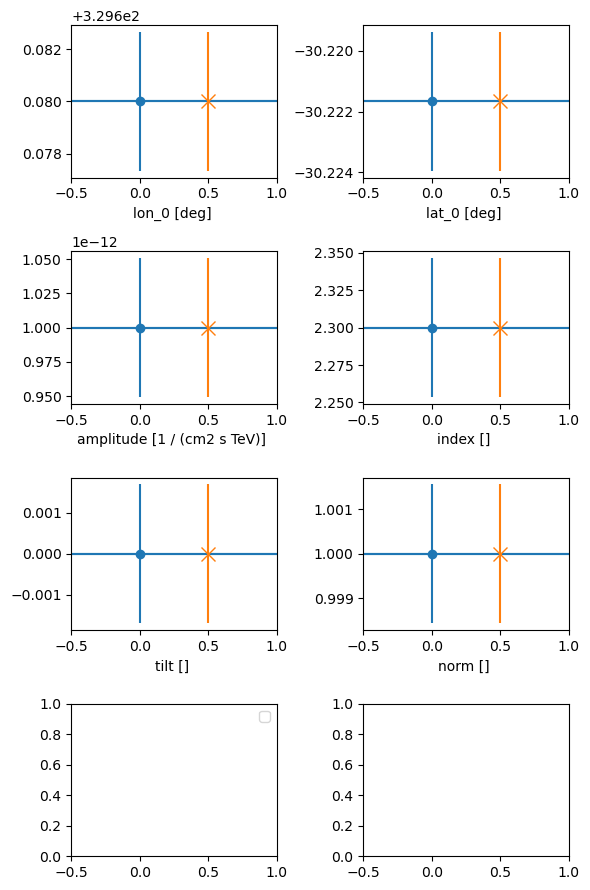

In [17]:
models_list = [dataset_asimov.models, dataset_asimov_cl.models ]

pars =  pars = ['lon_0', 'lat_0' , 'amplitude', 'index','tilt', 'norm', 'sigma']
plot_source_par_one(0, pars)


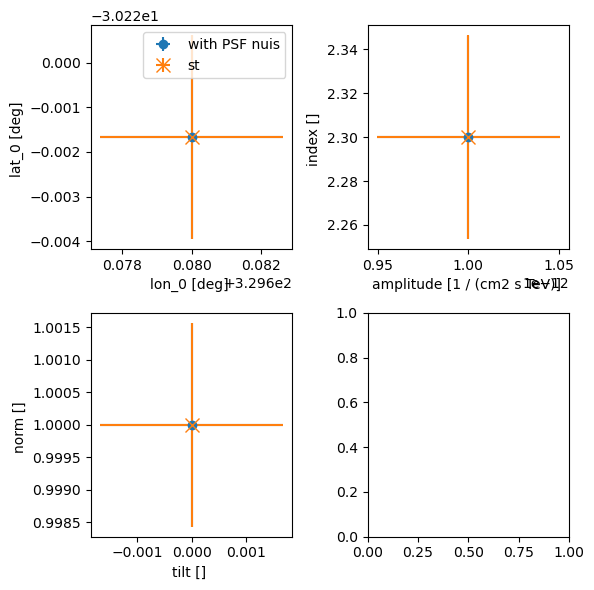

In [18]:
models_list = [dataset_asimov.models, dataset_asimov_cl.models ]

pars =  pars = [('lon_0', 'lat_0'),('amplitude', 'index'), ('tilt', 'norm')]
plot_source_par(0, pars)


In [19]:

print(dataset_asimov.models.parameters.to_table())

   type      name      value         unit        error      min        max     frozen is_norm is_penalised link
--------- --------- ----------- -------------- --------- ---------- ---------- ------ ------- ------------ ----
 spectral     index  2.3000e+00                4.626e-02        nan        nan  False   False        False     
 spectral amplitude  1.0000e-12 cm-2 s-1 TeV-1 5.055e-14        nan        nan  False    True        False     
 spectral reference  1.0000e+00            TeV 0.000e+00        nan        nan   True   False        False     
  spatial     lon_0  3.2968e+02            deg 2.644e-03  3.287e+02  3.307e+02  False   False        False     
  spatial     lat_0 -3.0222e+01            deg 2.284e-03 -3.122e+01 -2.922e+01  False   False        False     
psf_model sigma_psf  1.1657e-05                5.288e-01  0.000e+00        nan  False   False         True     
 spectral      norm  1.0000e+00                1.565e-03        nan        nan  False    True        Fal

In [20]:
print(dataset_asimov_cl.models.parameters.to_table())

  type      name      value         unit        error      min        max     frozen is_norm is_penalised link
-------- --------- ----------- -------------- --------- ---------- ---------- ------ ------- ------------ ----
spectral     index  2.3000e+00                4.634e-02        nan        nan  False   False        False     
spectral amplitude  1.0000e-12 cm-2 s-1 TeV-1 5.065e-14        nan        nan  False    True        False     
spectral reference  1.0000e+00            TeV 0.000e+00        nan        nan   True   False        False     
 spatial     lon_0  3.2968e+02            deg 2.646e-03  3.287e+02  3.307e+02  False   False        False     
 spatial     lat_0 -3.0222e+01            deg 2.281e-03 -3.122e+01 -2.922e+01  False   False        False     
spectral      norm  1.0000e+00                1.565e-03        nan        nan  False    True        False     
spectral      tilt  0.0000e+00                1.690e-03        nan        nan  False   False        False     
s

In [21]:
config = Dataset_load.load_config()
colors = config['colors']['one']

color_standard = colors[0]; color_standard_e = colors[2] #mediumvioletred
color_nui = colors[1]; color_nui_e = colors[3]
color_input = 'darkorange'
color_rnd = 'darkgreen'


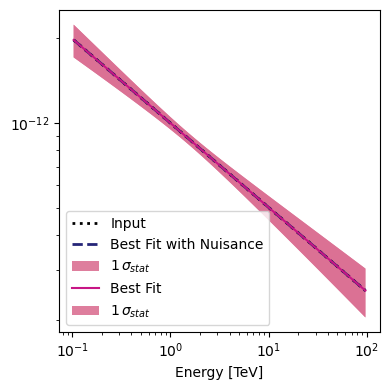

In [22]:


fig,axs = plt.subplots(1,1, sharey=True,figsize = (4,4))
axs = [ axs]

energy_bounds = [0.1,100]*u.TeV
ax = axs[0]
dataset_input.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                        label = "Input", color = 'black', linewidth = 2, linestyle="dotted")

dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color=color_nui,
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor=color_standard_e,
                                                          alpha = 0.9,
                                                          label= "1$\,\sigma_{stat}$"
                                                         )


dataset_asimov_cl.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Best Fit", color = color_standard)
dataset_asimov_cl.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax =ax,
                                                       facecolor=color_standard_e,
                                                          alpha = 0.9,
                                                          label= "1$\,\sigma_{stat}$"
                                                         )
axs[0].legend(loc='lower left')
#axs[0].set_ylim(5e-14,3e-12) 
axs[0].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
